## Implementation of Explore Then Commit

In [135]:
import numpy as np
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [136]:
# Helper functions for all algorithms 
def nsw(mu_matrix, policy):
    """
    Computes the Net Social Welfare (NSW) given a utility matrix and a policy.
    """

    expected_utilities = np.dot(mu_matrix, policy)
    #nash social welfare is product of expected utilities
    nsw = np.prod(expected_utilities)
    return nsw

def get_objective_func(mu_matrix):

    def objective_func(p):
        p = np.asarray(p)
        expected_utilities = np.dot(mu_matrix, p)
        nsw = np.prod(expected_utilities)
        return -1 * nsw
    
    return objective_func


def get_optimal_policy(mu_matrix):
    """
    Get the policy from the objective function.
    """

    # Objective function
    objective = get_objective_func(mu_matrix)

    # Constraint 
    def constraint(p):
        return 1 - sum(p)

    # Bounds and constraints
    bounds = [(0, 1)] * mu_matrix.shape[1]
    constraints = [{'type': 'eq', 'fun': constraint}]
    initial_guess = np.ones(mu_matrix.shape[1]) / mu_matrix.shape[1]

    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')

    return result.x

In [137]:
#This function performs the Explore-Then-Commit algorithm with N agents and K arms. Each arm is gaussian with stdev = 0.1
def explore_then_commit(mu_matrix, horizon, num_simulations, tradeoff=False):

    optimal_policy = get_optimal_policy(mu_matrix)
    optimal_nsw = nsw(mu_matrix, optimal_policy)
    regrets = []
    policies = []   

    num_agents = mu_matrix.shape[0]
    num_arms = mu_matrix.shape[1]

    #exploration period
    if tradeoff:
        exploration_period = int((num_agents ** (1/3)) * (num_arms ** (-1/3)) * (horizon ** (2/3)) * (np.log(horizon*num_agents*num_arms) ** (2/3)))
    else:
        exploration_period = int((num_agents ** (2/3)) * (num_arms ** (-2/3)) * (horizon ** (2/3)) * (np.log(horizon*num_agents*num_arms) ** (1/3))) 

    for i in tqdm(range(num_simulations)):

        # Step 0: Initialize variables
        regret = 0
        mu_hat_matrix = np.zeros(mu_matrix.shape)
        
        #for computing estimators
        mu_hat_totals = np.zeros(mu_matrix.shape)
        mu_hat_counts = np.ones(mu_matrix.shape) * exploration_period

        # Step 1: Exploration, pull each arm for each agent exploration period times

        for k in range(mu_matrix.shape[1]):
            for t in range(exploration_period):
                for j in range(mu_matrix.shape[0]):
                    #sample from arm k for agent j
                    sample = np.random.normal(mu_matrix[j][k], 0.1)
                    mu_hat_totals[j][k] += sample

                #policy for this round is a one hot vector over arms with position k = 1
                policy = np.zeros(mu_matrix.shape[1])
                policy[k] = 1
                    
                # Now we update regret based on the policy for this round 
                regret += (optimal_nsw - nsw(mu_matrix, policy)) 

        # Step 2: Compute the empirical means
        mu_hat_matrix = mu_hat_totals / mu_hat_counts

        # Step 3: Compute the optimal policy based on the empirical means
        policy_exploit = get_optimal_policy(mu_hat_matrix)
        policies.append(policy_exploit)

        regret += (optimal_nsw - nsw(mu_matrix, policy_exploit))* (horizon - exploration_period)

        regrets.append(regret)

    return regrets, policies

Here we try it out with a 3 agents and 3 arms where each agent prefers a different arm. We are using 10 horizons spaced evenly between 10^3 and 10^5 and 10 simulations per horizon. 

100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


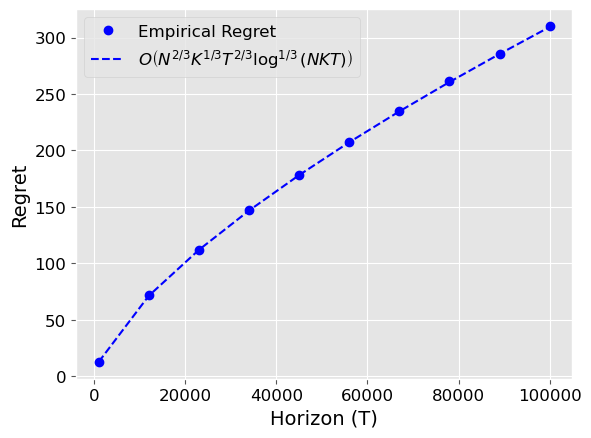

In [138]:
#try 3x3 test array
mu_matrix = np.array([[0.3, 0.5, 0.7],
                        [0.7, 0.3, 0.5],
                        [0.5, 0.7, 0.3]])

#try explore then commit for different horizons from 1000 to 100000
horizons = np.linspace(10**3, 10**5, 10)    

with plt.style.context('ggplot'):
    #for each horizon, run the explore then commit algorithm and plot the regrets, with stderror bars across the simulations
    for horizon in horizons:
        regrets, policies = explore_then_commit(mu_matrix, horizon=int(horizon), num_simulations=10)
        mean_regret = np.mean(regrets)
        std_error = np.std(regrets) / np.sqrt(len(regrets))

        # Plotting the results
        plt.errorbar(horizon, mean_regret, yerr=std_error, marker='o', color='b')

    plt.plot([], [], 'ob', label='Empirical Regret')

    #plot theoretical regret bound 
    num_agents = mu_matrix.shape[0]
    num_arms = mu_matrix.shape[1]
    C = 0.02 # determined empirically 
    theoretical_regret = C * num_agents**(2/3) * num_arms**(1/3) * (horizons**(2/3)) * (np.log(horizons*num_agents*num_arms)**(1/3))
    plt.plot(horizons, theoretical_regret, 'b--', label=r'$O\left(N^{2/3} K^{1/3} T^{2/3} \log^{1/3}(NKT)\right)$')

    plt.xlabel('Horizon (T)', fontsize=14, color='black')
    plt.ylabel('Regret', fontsize=14, color='black')
    plt.tick_params(axis='both', labelsize=12, labelcolor='black')
    plt.legend(fontsize=12, loc='upper left')
    plt.show()

Now we can select one horizon (10^4) and do 30 simulations, where now we visualize the true NSW and the distribution of policies used in the exploit stage of the algorithm over the 30 simulations. 

100%|██████████| 30/30 [00:01<00:00, 19.17it/s]


Optimal p1: 0.3333333333333333
Optimal p2: 0.3333333333333333
Optimal p3: 0.3333333333333333


/var/folders/mf/2cn54l592v59ftz5czx_4x_m0000gn/T/ipykernel_1175/326250122.py:66: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(surf, format='%.3f', shrink=0.8, aspect=10, pad=0.1)


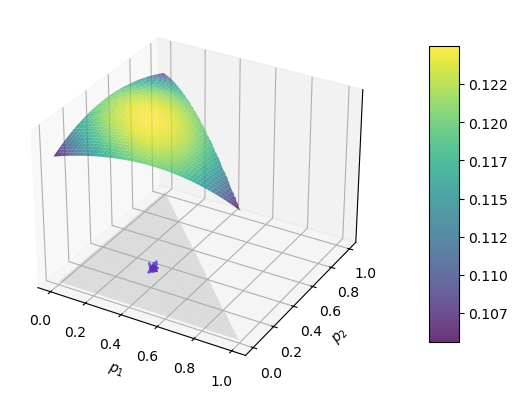

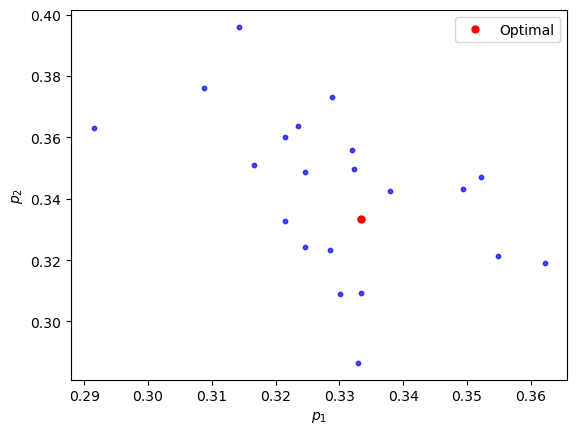

In [151]:
mu_matrix = np.array([[0.3, 0.5, 0.7,],
                       [0.7, 0.3, 0.5],
                       [0.5, 0.7, 0.3]])

regrets, policies = explore_then_commit(mu_matrix, horizon=10**4, num_simulations=30)

objective = get_objective_func(mu_matrix)
# Optimization
optimal_p1, optimal_p2, optimal_p3 = get_optimal_policy(mu_matrix)

print(f"Optimal p1: {optimal_p1}")
print(f"Optimal p2: {optimal_p2}")
print(f"Optimal p3: {optimal_p3}")

# Grid setup
p1_vals = np.linspace(0, 1, 200)
p2_vals = np.linspace(0, 1, 200)
P1, P2 = np.meshgrid(p1_vals, p2_vals)
P3 = 1 - P1 - P2

# Create mask for valid (feasible) region
mask = P3 >= 0

# Compute Z only where the mask is valid
Z = np.full(P1.shape, np.nan)
for i in range(P1.shape[0]):
    for j in range(P1.shape[1]):
        if mask[i, j]:
            Z[i, j] = -1 * objective([P1[i, j], P2[i, j], P3[i, j]])

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Objective surface
surf = ax.plot_surface(P1, P2, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Shade feasible region in xy-plane (z=0)
Z_plane = np.zeros_like(P1)
Z_plane[~mask] = np.nan  # Hide infeasible part
ax.plot_surface(P1, P2, Z_plane, color='lightgray', alpha=0.3)


fig2, ax2 = plt.subplots()
ax2.plot(optimal_p1, optimal_p2, 'ro', label='Optimal', markersize=5)

# Plot optimal point
ax.plot([optimal_p1], [optimal_p2], [0], 'ro', markersize=5)

p1s = [policy[0] for policy in policies]
p2s = [policy[1] for policy in policies]
# Plot policies
ax.plot([p1s], [p2s], [0], 'b', markersize=5, alpha=0.7)
ax2.scatter(p1s, p2s, 10, color='b', alpha=0.7)


ax2.set_xlabel(r'$p_1$')
ax2.set_ylabel(r'$p_2$')
ax2.legend()

# Labels and display
ax.set_xlabel(r'$p_1$')
ax.set_ylabel(r'$p_2$')
ax.set_zticks([])
ax.set_zticklabels([])
cbar = plt.colorbar(surf, format='%.3f', shrink=0.8, aspect=10, pad=0.1)
cbar.ax.tick_params(labelsize=10)


plt.show()

Now we will illustrate the tradeoff from the paper between the number of agents and number of arms by using the same set up as before but with 100 agents and 2 arms. 

100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


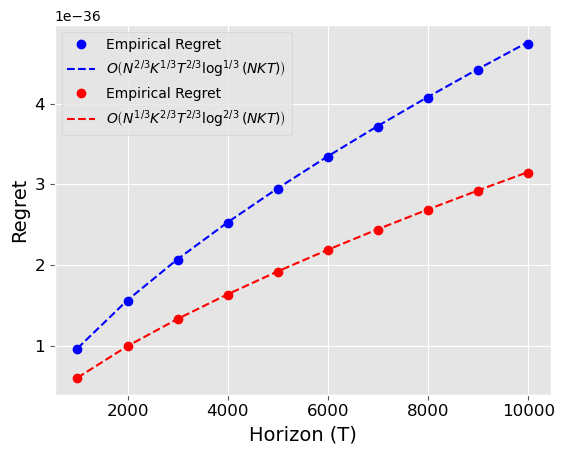

In [140]:
#100 agents, and 2 arms
mu_matrix = np.array([[0.3, 0.5] * 50, 
                      [0.5, 0.3] * 50]).reshape(100, 2)
                      
#plot theoretical regret bound
num_agents = mu_matrix.shape[0]
num_arms = mu_matrix.shape[1]

#try explore then commit for different horizons from 1000 to 100000
horizons = np.linspace(10**3, 10**4, 10)    

with plt.style.context('ggplot'):

    #for each horizon, run the explore then commit algorithm and plot the regrets, with stderror bars across the simulations
    for horizon in horizons:
        regrets, policies = explore_then_commit(mu_matrix, horizon=int(horizon), num_simulations=5)
        mean_regret = np.mean(regrets)
        std_error = np.std(regrets) / np.sqrt(len(regrets))

        # Plotting the results
        plt.errorbar(horizon, mean_regret, yerr=std_error, marker='o', color='b')


    plt.plot([], [], 'ob', label='Empirical Regret')

    C1 = 1.55e-40 # determined empirically 
    theoretical_regret_1 = C1 * num_agents**(2/3) * num_arms**(1/3) * (horizons**(2/3)) * (np.log(horizons*num_agents*num_arms)**(1/3))
    plt.plot(horizons, theoretical_regret_1, 'b--', label=r'$O\left(N^{2/3} K^{1/3} T^{2/3} \log^{1/3}(NKT)\right)$')

    for horizon in horizons:
        regrets, policies = explore_then_commit(mu_matrix, horizon=int(horizon), num_simulations=5, tradeoff=True)
        mean_regret = np.mean(regrets)
        std_error = np.std(regrets) / np.sqrt(len(regrets))

        # Plotting the results
        plt.errorbar(horizon, mean_regret, yerr=std_error, marker='o', color='r')


    plt.plot([], [], 'or', label='Empirical Regret')

    C2 = 1.55e-40 # determined empirically 
    theoretical_regret_2 = C2 * num_agents**(1/3) * num_arms**(2/3) * (horizons**(2/3)) * (np.log(horizons*num_agents*num_arms)**(2/3))
    plt.plot(horizons, theoretical_regret_2, 'r--', label=r'$O\left(N^{1/3} K^{2/3} T^{2/3} \log^{2/3}(NKT)\right)$')

    plt.xlabel('Horizon (T)', fontsize=14, color='black')
    plt.ylabel('Regret', fontsize=14, color='black')
    plt.tick_params(axis='both', labelsize=12, labelcolor='black')
    plt.legend(fontsize=10, loc='upper left')
    plt.show()


100%|██████████| 5/5 [00:25<00:00,  5.03s/it]


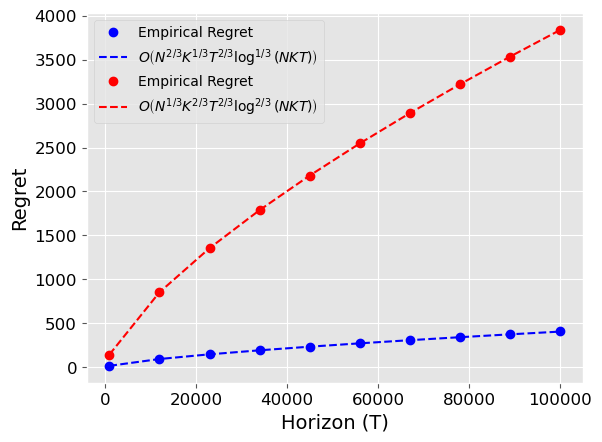

In [141]:
mu_matrix = np.array([[0.3, 0.5] * 50, 
                      [0.5, 0.3] * 50]).reshape(2, 100)

#plot theoretical regret bound
num_agents = mu_matrix.shape[0]
num_arms = mu_matrix.shape[1]

#try explore then commit for different horizons from 1000 to 100000
horizons = np.linspace(10**3, 10**5, 10)    

with plt.style.context('ggplot'):
    #for each horizon, run the explore then commit algorithm and plot the regrets, with stderror bars across the simulations
    for horizon in horizons:
        regrets, policies = explore_then_commit(mu_matrix, horizon=int(horizon), num_simulations=5)
        mean_regret = np.mean(regrets)
        std_error = np.std(regrets) / np.sqrt(len(regrets))

        # Plotting the results
        plt.errorbar(horizon, mean_regret, yerr=std_error, marker='o', color='b')

    plt.plot([], [], 'ob', label='Empirical Regret')

    C1 = 0.01 # determined empirically 
    theoretical_regret_1 = C1 * num_agents**(2/3) * num_arms**(1/3) * (horizons**(2/3)) * (np.log(horizons*num_agents*num_arms)**(1/3))
    plt.plot(horizons, theoretical_regret_1, 'b--', label=r'$O\left(N^{2/3} K^{1/3} T^{2/3} \log^{1/3}(NKT)\right)$')

    for horizon in horizons:
        regrets, policies = explore_then_commit(mu_matrix, horizon=int(horizon), num_simulations=5, tradeoff=True)
        mean_regret = np.mean(regrets)
        std_error = np.std(regrets) / np.sqrt(len(regrets))

        # Plotting the results
        plt.errorbar(horizon, mean_regret, yerr=std_error, marker='o', color='r')

    plt.plot([], [], 'or', label='Empirical Regret')

    C2 = 0.01 # determined empirically 
    theoretical_regret_2 = C2 * num_agents**(1/3) * num_arms**(2/3) * (horizons**(2/3)) * (np.log(horizons*num_agents*num_arms)**(2/3))
    plt.plot(horizons, theoretical_regret_2, 'r--', label=r'$O\left(N^{1/3} K^{2/3} T^{2/3} \log^{2/3}(NKT)\right)$')

    plt.xlabel('Horizon (T)', fontsize=14, color='black')
    plt.ylabel('Regret', fontsize=14, color='black')
    plt.tick_params(axis='both', labelsize=12, labelcolor='black')
    plt.legend(fontsize=10, loc='upper left')
    plt.show()
